# Data analysis

In [5]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# update some global settings for plots
plt.rcParams.update({
    'font.family': 'sans-serif',  
    'font.size': 11, 
    'font.weight': 'heavy',
    'axes.labelweight': 'heavy',
    'axes.titleweight': 'heavy',
})

## Preprocessing

In [3]:
# load retrieved data
mkp_waveforms = pd.read_parquet('./data/data_mkp_ipoc_raw.pqt')
print(mkp_waveforms.shape)

(111843, 28)


In [4]:
# Check for missing values in each column
missing_values = mkp_waveforms.isna().any()

print(missing_values[missing_values == True])

cycle_name_tmr1    True
delay_tmr3         True
risetime_tmr3      True
i_max_tmr3         True
dtype: bool


There are values missing from four columns: cycle_name_tmr1, delay_tmr3, risetime_tmr3, i_max_tmr3. The first one is critical, as the waveform-behaviour can differ systematically between cycles. The value is missing for a single row, which will be removed.

The other three columns all concern the same switch (switch 3). The values are all missing for the same row. Possibly, the instrument that measures the current failed at that time. As a single row does not influence the distribution significantly (over 100000 rows in total), this row will be removed as well.

In [14]:
# remove the rows with missing values
mkp_waveforms = mkp_waveforms.drop([36880, 577250])

In [15]:
# raw timestamps are logged in unix format (nanosecond precision)
# convert to human readable format
mkp_waveforms['timestamp'] = mkp_waveforms['date_ppm'].apply(lambda x: pd.Timestamp(x))

In [16]:
# rise times are logged in milliseconds, convert to nanoseconds
for i in np.arange(1, 9):
    mkp_waveforms['risetime_tmr{}'.format(i)] = mkp_waveforms['risetime_tmr{}'.format(i)].apply(lambda x: x * 1000)

## Analysis

In [17]:
# display descriptive statistics for the rise times
pd.set_option('display.float_format', '{:.2f}'.format)

mkp_waveforms[['risetime_tmr{}'.format(i) for i in np.arange(1, 9)]].describe()

risetime_tmr1  risetime_tmr2  risetime_tmr3  risetime_tmr4  \
count      111841.00      111841.00      111841.00      111841.00   
mean           51.16          44.74          53.77          42.60   
std            19.51           1.11           0.30           0.94   
min            28.75          43.48           0.22           0.27   
25%            43.84          43.98          53.71          41.75   
50%            43.95          44.10          53.78          42.30   
75%            44.03          45.30          53.85          43.66   
max           104.28          51.08          55.30          44.78   

       risetime_tmr5  risetime_tmr6  risetime_tmr7  risetime_tmr8  
count      111841.00      111841.00      111841.00      111841.00  
mean           42.87          43.53          42.99          41.00  
std             0.12           0.24           0.31           0.12  
min            41.63          41.52          40.51          39.12  
25%            42.84          43.38          42.89          40.93  
50%            42.88          43.45          42.96          41.01  
75%            42.93          43.72          43.05          41.09  
max            43.77          45.28          51.93          48.93

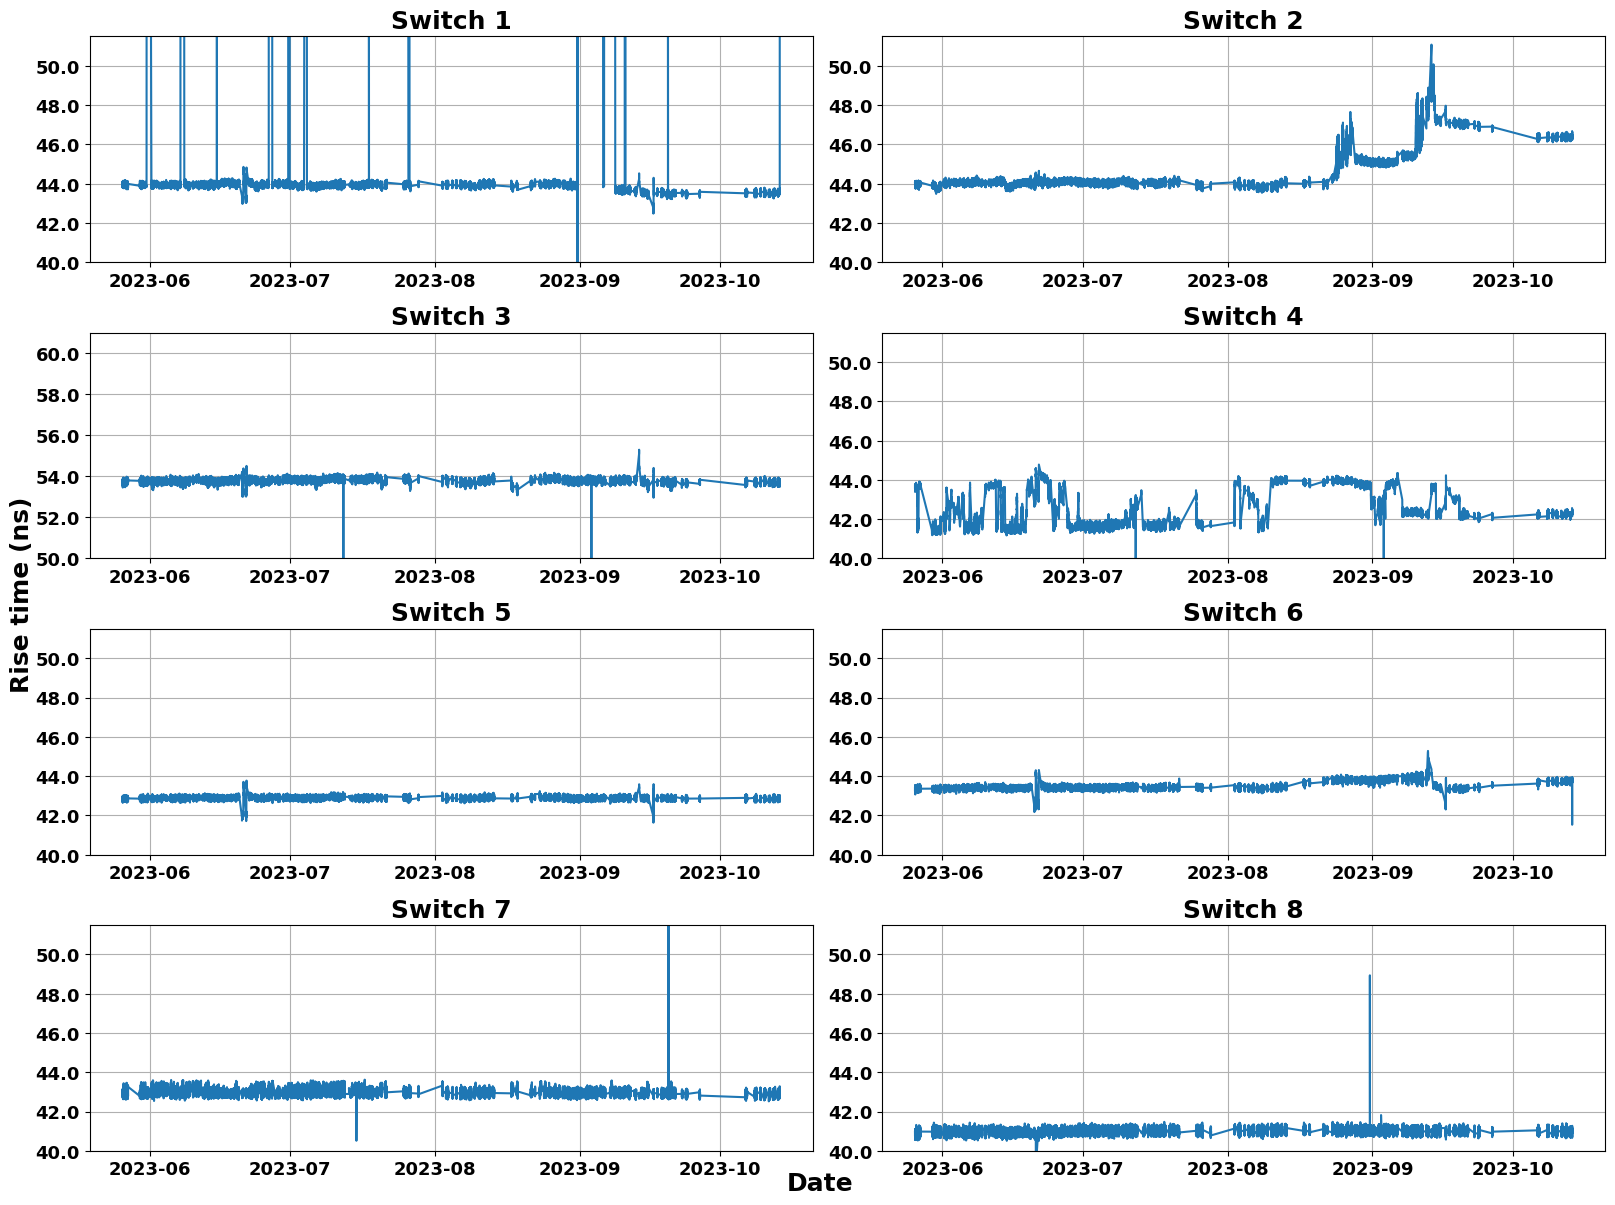

In [19]:
# plot rise times over the retrieved time-frame for each switch
fig, ax = plt.subplots(4, 2, figsize=(16, 12))
idx = 1
for i in np.arange(0, 4):
    for j in np.arange(0, 2):
        ax[i, j].plot(mkp_waveforms['timestamp'], mkp_waveforms['risetime_tmr{}'.format(idx)])
        ax[i, j].set_title('Switch {}'.format(idx), fontsize=18)
        ax[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax[i, j].tick_params(axis='x', labelsize=13)
        ax[i, j].tick_params(axis='y', labelsize=13)
        ax[i, j].set_ylim(bottom=40.0, top=51.5)
        ax[i, j].grid()
        
        # zoom in on the relevant data
        if i == 1:
            if j == 0:
                ax[i, j].set_ylim(bottom=50.0, top=61.0)
        
        idx += 1

fig.tight_layout(pad=1.0)

# Set common labels
fig.text(0.5, 0.009, 'Date', ha='center', va='center', fontsize=18)
fig.text(0.001, 0.5, 'Rise time (ns)', ha='center', va='center', rotation='vertical', fontsize=18)

plt.savefig('plots/historical_rise_times_ts.pdf', bbox_inches='tight')

## Non-mitigable Losses

Due to the shape of the waveforms and restrictions imposed by the circulating beam, some non-mitigable arise for the injected beam. Under the assumption of accepting up to 25% of the flat-top kick for the circulating beam, these losses were quantified.

In [7]:
# number of magnets per module
mkp1_module_nr = 5
mkp2_module_nr = 5
mkp3_module_nr = 2
mkp4_module_nr = 4
module_nrs = [mkp1_module_nr, mkp2_module_nr, mkp3_module_nr, mkp4_module_nr]

In [8]:
# design kicks according to MADX sequence
mkp_volt = 52
mkpa_kv2rad = 2.036307619e-05
mkpc_kv2rad = 8.140618226e-06
mkpl_kv2rad = 2.147001577e-05

# kicks for the entire module, consisting of multiple magnets each
module_kicks = np.array([mkpa_kv2rad * mkp_volt,
                         mkpa_kv2rad * mkp_volt,
                         mkpc_kv2rad * mkp_volt,
                         mkpl_kv2rad * mkp_volt])

# retrieve kicks for the individual magnets
magnet_kicks = []

for i in np.arange(0, len(module_nrs)):
    for j in np.arange(0, module_nrs[i]):
        magnet_kicks.append(module_kicks[i] / module_nrs[i])

In [9]:
# load example set of waveforms
kick_data = np.genfromtxt('data/sps_lhcpilot_kick_data.txt')

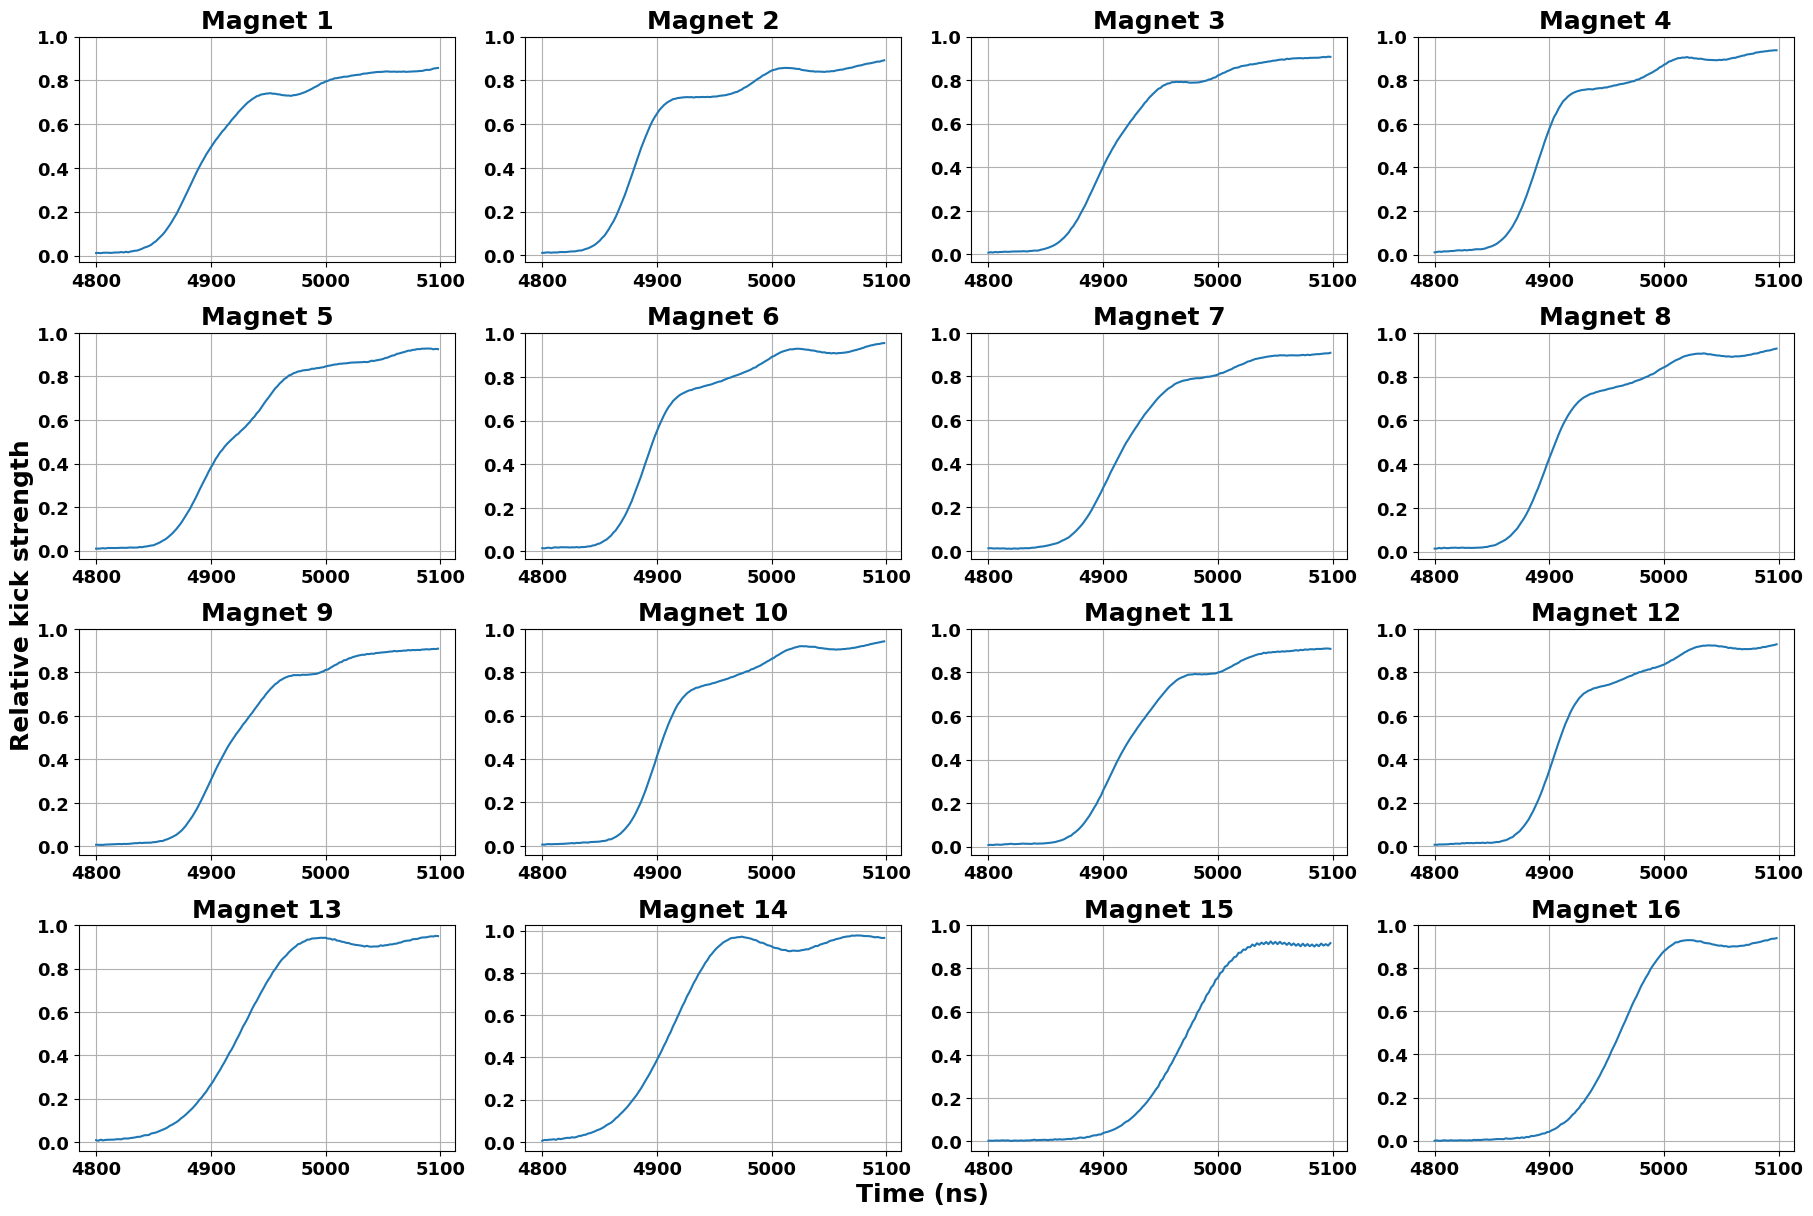

In [11]:
# plot normalized waveforms of all magnets (1.0 = design kick)
fig, ax = plt.subplots(4, 4, figsize=(18, 12))
i = 0
j = 0
count = 0

for ele in kick_data:
    ax[i, j].plot(np.arange(0, len(ele), 2)[2400:2550], ele[2400:2550] / magnet_kicks[count])
    ax[i, j].set_yticks(np.arange(0, 1.1, 0.2))
    ax[i, j].set_title('Magnet {}'.format(count+1), fontsize=18)
    ax[i, j].tick_params(axis='x', labelsize=13)
    ax[i, j].tick_params(axis='y', labelsize=13)
    ax[i, j].grid()
    
    j += 1
    if j == 4:
        j = 0
        i += 1
    count += 1

fig.tight_layout(pad=1.0)

# Set common labels
fig.text(0.5, 0.0, 'Time (ns)', ha='center', va='center', fontsize=18)
fig.text(0.0, 0.5, 'Relative kick strength', ha='center', va='center', rotation='vertical', fontsize=18)

plt.savefig('plots/kick_residuals.pdf', bbox_inches='tight')

In [12]:
# load normalized factors to convert voltage into kick
with open('data/conversion_factors_normalized.pkl', 'rb') as f:
    conversion_factors = pickle.load(f)

In [13]:
# load training data (kick) and convert to original shape
mkp_kick_data = np.genfromtxt('data/sps_kick_data_train_1.txt')
mkp_kick_data = mkp_kick_data.reshape(16, int(mkp_kick_data.shape[1] / 10000), 10000)
for i in np.arange(2, 5):
    data = np.genfromtxt('data/sps_kick_data_train_{}.txt'.format(i))
    data = data.reshape(16, int(data.shape[1] / 10000), 10000)
    mkp_kick_data = np.concatenate((mkp_kick_data, data), axis=1)


In [14]:
# determine the maximum achievable kick for the injected beam under the constraint of 25% or less of the design kick given to the circulating beam
max_kick = np.zeros([mkp_kick_data.shape[0], mkp_kick_data.shape[1]])

for i in np.arange(mkp_kick_data.shape[1]):  # iterate over all sets of waveforms
    for j in np.arange(mkp_kick_data.shape[0]):  # iterate over every waveform in the set
        mkp_kick_data[j, i, :] = mkp_kick_data[j, i, :] / np.max(mkp_kick_data[j, i, :]) * conversion_factors[j] / magnet_kicks[j]  # relative kick
        
        idx = np.argmax(mkp_kick_data[j, i, :] >= 0.25)  # up to 25% of design kick is accepted for the circulating beam
        max_kick[j, i] = np.max(mkp_kick_data[j, i, 0:(idx + 100)])

In [15]:
# calculate the mean non-mitigable loss for each kicker magnet
print(1 - np.mean(max_kick, 1))

[0.15738156 0.13997946 0.09367621 0.07519311 0.07070843 0.06949604
 0.09388629 0.08566603 0.09204812 0.06584223 0.09059026 0.07648451
 0.05122797 0.0164779  0.05417337 0.04922576]


Non-mitigable losses up to 15.74% were found.